In [1]:
#from pymongo import MongoClient
import pandas as pd
import numpy as np
from os import path

In [2]:
##########################################################################
def extractIds(T):
    import re
    courseID=''
    activityID=''
    compID=''
    activityType=''
    compType=''
    for i in T :
        if 'course' in i :
            courseID=re.sub('^.*course\/view\.php\?id=','',i)
        elif 'review' in i :
                activityType='Quiz'
                compID=re.sub('^.*review\.php\?attempt=','',i)
                compType='Attempt'
        elif 'mod' in i :
            if "quiz/view" in i:
                activityType='Quiz'
                activityID=re.sub('^.*quiz\/view\.php\?id=','',i)
            elif "attempt.php" in i:
                activityType='Quiz'
                compID=re.sub('^.*attempt\.php\?attempt=(.*)\&.*$',r'\1',i)
                compType='Attempt'
            elif "assign/view" in i:
                activityType='Assignement'
                activityID=re.sub('^.*assign\/view\.php\?id=','',i)
            elif "ressource/view" in i:
                activityType='Ressource'
                activityID=re.sub('^.*ressource\/view\.php\?id=','',i)
            elif "book/view" in i:
                activityType='Book'
                if 'chapterid' in i :
                    activityID=re.sub('^.*book\/view\.php\?id=([0-9])\&.*$',r'\1',i)
                    compID=re.sub('^.*book\/view\.php\?id.*chapterid=',r'',i)
                    compType='Chapter'
                else:
                    activityID=re.sub('^.*book\/view\.php\?id=','',i)
            elif "folder/view" in i:
                activityType='Folder'
                activityID=re.sub('^.*folder\/view\.php\?id=','',i)
            elif "url/view" in i:
                activityType='Url'
                activityID=re.sub('^.*url\/view\.php\?id=','',i)
            elif "forum" in i:
                activityType='Forum'
                if 'view' in i:
                    activityID=re.sub('^.*forum\/view\.php\?id=','',i)                  
                elif 'discuss' in i :
                    activityID=re.sub('^.*forum\/discuss\.php\??id=','',i)
                    
    return {'courseID':courseID,
            'activityType':activityType,
            'activityID':activityID,
            'complementType':compType,
            'complementID':compID
            }
#####################################
def add_session_old(log_moodle_file: pd.DataFrame,inactive_duration:int )-> pd.DataFrame :    
#create session :
# temps minimum pour une nouvelle session en minutes

    delta_time = np.timedelta64(inactive_duration,'m')
    log_moodle_file.sort_values(by=['User','Timestamp'],inplace=True,ascending=True)
    log_moodle_file['Session'] = "None"
#    cols=log_moodle_file.columns.tolist()
#    log_moodle_file=log_moodle_file[cols[:1]+cols[-1:]+cols[1:-1]]
    D=log_moodle_file.Timestamp.copy()
    Mydates=np.array(D.values, dtype='datetime64[s]').copy()
    Ddate=np.ediff1d(Mydates)
    log_moodle_file['Session']=np.append([0],np.cumsum((abs(Ddate)>delta_time)*1))
    return log_moodle_file
#####################################
def add_session(log_moodle_file: pd.DataFrame,inactive_duration:int )-> pd.DataFrame :    
#create session :
# temps minimum pour une nouvelle session en minutes
    delta_time = np.timedelta64(inactive_duration,'m')
    log_moodle_file.sort_values(by=['User','Timestamp'],inplace=True,ascending=True)
    log_moodle_file['Session'] = "None"
    Mydates=np.array(log_moodle_file['Timestamp'].values, dtype='datetime64[s]')
    Ddate=np.ediff1d(Mydates)
    log_moodle_file['Session']=np.append([0],np.cumsum((abs(Ddate)>delta_time)*1))
    return log_moodle_file
################## Indicateurs ###################
def I1a(UTPD,a):
    import math
    UTPD=UTPD.fillna(0)
    i=((UTPD[a]-UTPD.mean(axis=1))/UTPD.std(axis=1)).mean()
#           -inf -1xEcT -1/2xEcT    0	1/2xEcT	  1xEcT		+inf 	
# nb stars	|	0	|	1	|	2	|	3	|	4	|	5	|	
# Proba     |	16%	|	15%	|	19%	|	19%	|	15%	|	16%	|	
    stars=max(min(math.floor(i*2)+3,5),0)
    stars_str="\u2605"*stars+"\u2606"*(5-stars)
    return stars_str

def I2a(UTPD,a):
    import math
    UTPD_tot=UTPD.fillna(0).sum(axis=0)
    i=(UTPD_tot[a]-UTPD_tot.mean())/UTPD_tot.std()
#           -inf -1xEcT -1/2xEcT    0	1/2xEcT	  1xEcT		+inf 	
# nb stars	|	0	|	1	|	2	|	3	|	4	|	5	|	
# Proba     |	16%	|	15%	|	19%	|	19%	|	15%	|	16%	|	
    stars=max(min(math.floor(i*2)+3,5),0)
    stars_str="\u2605"*stars+"\u2606"*(5-stars)
    return stars_str

def I3a(UTPD,a):
    import math
    UTPD=UTPD.fillna(0)
    i=((UTPD[a]-UTPD.mean(axis=1))/UTPD.std(axis=1)).std()
#           -inf -1xEcT -1/2xEcT    0	1/2xEcT	  1xEcT		+inf 	
# nb stars	|	0	|	1	|	2	|	3	|	4	|	5	|	
# Proba     |	16%	|	15%	|	19%	|	19%	|	15%	|	16%	|	
    stars=max(min(math.floor(i*2)+3,5),0)
    stars_str="\u2605"*stars+"\u2606"*(5-stars)
    return stars_str


##########################################################################


In [3]:
Real_request = False
dfs_filename = "LU2ST031_LRS20.csv"
statement_output_filename = "statement_output.csv"
activities_output_filename = "statement_output.csv"
course_base_url="https://moodle-sciences.upmc.fr/moodle-2020/course/view.php?id="
course_id=11
new_session_after=15


course_url=course_base_url+str(course_id)


In [4]:
if path.exists(r"data/"+dfs_filename):
    DFS=pd.read_csv(r"data/"+dfs_filename).set_index('Unnamed: 0')
    DFS["Timestamp"]=pd.to_datetime(DFS["Timestamp"],utc=True)
    DFS['User']=DFS['User'].astype('str')
else :
    print("fichier ",dfs_filename," introuvable")

In [5]:
DFS

,Timestamp,User,Action,courseID,activityType,activityID,complementType,complementID,Session
Unnamed: 0,,,,,,,,,
434,2020-09-16 15:58:15+00:00,10161,enrolled to,11,NaN,NaN,NaN,NaN,0
1037,2020-09-18 07:44:50+00:00,10161,viewed,11,NaN,NaN,NaN,NaN,1
1039,2020-09-18 07:45:24+00:00,10161,viewed,11,NaN,NaN,NaN,NaN,1
1041,2020-09-18 07:47:41+00:00,10161,viewed,11,NaN,NaN,NaN,NaN,1
1043,2020-09-18 07:48:24+00:00,10161,viewed,11,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...
61089,2020-10-30 16:01:19+00:00,89,viewed,11,Quiz,103,Attempt,17004279.0,5267
61090,2020-10-30 16:02:51+00:00,89,viewed,11,NaN,NaN,NaN,NaN,5267
61091,2020-10-30 16:02:54+00:00,89,viewed,11,NaN,NaN,NaN,NaN,5267


In [6]:
D1=DFS.groupby('Session')
D1f=D1.first()
D1f.rename(columns={'Timestamp':'Start'},inplace=True)
D1l=D1.last()
D1l.rename(columns={'Timestamp':'End'},inplace=True)

SESSIONS=D1f[['User','courseID','Start']].join(D1l[['End']])
SESSIONS['Duration']=(SESSIONS['End']-SESSIONS['Start']).astype('timedelta64[m]')
SESSIONS['Startdate']=pd.to_datetime(SESSIONS.Start.dt.date)
USER_TIME_PER_DAY=SESSIONS[['User','Startdate','Duration']].groupby(['User','Startdate']).sum()
# SESSIONS :
# Columns : 'User', 'courseID', 'Start' (datetime64[ns,UTC]), 'End' (datetime64[ns,UTC]), 'Duration' (en minutes float64), 'Startdate'  (datetime64[ns])
# Index : 'Session' (numérotation continue d'un utilisateur à l'autre)
 
Index=USER_TIME_PER_DAY.index.levels
Users=Index[0]
Dates=Index[1]
NewIndex=pd.MultiIndex.from_product([Users, pd.date_range(start=Dates.min(), end=Dates.max(), freq='D')],names=['User','Startdate'])
USER_TIME_PER_DAY=USER_TIME_PER_DAY.reindex(NewIndex)
USER_TIME_PER_DAY=USER_TIME_PER_DAY.unstack('User').droplevel(0,axis=1)
# USER_TIME_PER_DAY (DF):
# Columns : users
# Index : date (jour)

USER_TIME_PER_WEEK=USER_TIME_PER_DAY.resample('W-Mon').sum()
# USER_TIME_PER_WEEK (DF):
# Columns : users
# Index : Week start date (jour)

ALL_TIME_PER_DAY=pd.DataFrame(USER_TIME_PER_DAY.mean(axis=1),columns=['Mean'])
ALL_TIME_PER_DAY=ALL_TIME_PER_DAY.join(pd.DataFrame(USER_TIME_PER_DAY.std(axis=1),columns=['Std']))
# ALL_TIME_PER_DAY (DF):
# Columns : Moyenne et std en min
# Index : date (jour)

ALL_TIME_PER_WEEK=pd.DataFrame(USER_TIME_PER_WEEK.mean(axis=1),columns=['Mean'])
ALL_TIME_PER_WEEK=ALL_TIME_PER_WEEK.join(pd.DataFrame(USER_TIME_PER_WEEK.std(axis=1),columns=['Std']))
# ALL_TIME_PER_WEEK (DF):
# Columns : Moyenne et std en min
# Index : Week start date (jour)

In [7]:
USER_TIME_PER_DAY

User,10161,12774,12926,13179,13357,13835,14380,14407,17181,18313,...,46665,46689,46890,47395,47640,47674,6476,7425,839,89
Startdate,,,,,,,,,,,,,,,,,,,,,
2020-07-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
USER_TIME_PER_WEEK

User,10161,12774,12926,13179,13357,13835,14380,14407,17181,18313,...,46665,46689,46890,47395,47640,47674,6476,7425,839,89
Startdate,,,,,,,,,,,,,,,,,,,,,
2020-07-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-08-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-08-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-08-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-08-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-08-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-14,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,23.0
2020-09-21,314.0,82.0,171.0,0.0,1.0,17.0,0.0,191.0,90.0,128.0,...,0.0,0.0,0.0,0.0,0.0,0.0,424.0,0.0,4.0,87.0


### EXEMPLE Pour une semaine à partir du 12 Oct 2020 - Moyenne et User '89'



Indicateur de temps total d'activité sur la semaine du 2020-10-12 :
Utilisateur 89 : ★★★☆☆


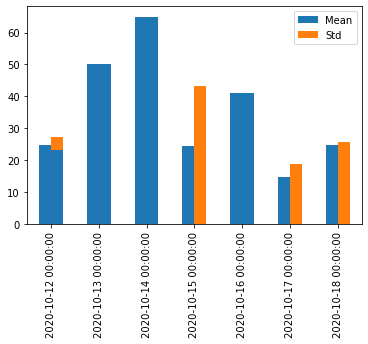

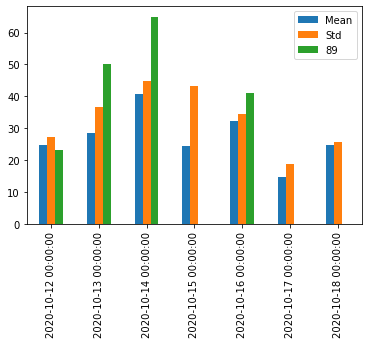

In [9]:
#EXEMPLE Pour une semaine à partir du 12 Oct 2020 - Moyenne et User '89'
StartingDay='2020-10-12'
User='89'
EX_ALL=ALL_TIME_PER_DAY.loc[pd.date_range(start=StartingDay,periods=7,freq='D')]
EX_USER=USER_TIME_PER_DAY.loc[pd.date_range(start=StartingDay,periods=7,freq='D'),User]
EX_ALL.plot.bar()
EX_USER.plot.bar()
pd.DataFrame(EX_ALL).join(pd.DataFrame(EX_USER)).plot.bar()

In [13]:

# Exemple d'usage pour les indicateurs
print("\n\n"+
      "Indicateur de temps total d'activité "+
      "sur la semaine du 2020-10-12 :\n")
print("Utilisateur "+User+" : "+
      I1a(USER_TIME_PER_DAY.loc['2020-10-12':'2020-10-18'],User))
print("Utilisateur 10161 : "+
      I1a(USER_TIME_PER_DAY.loc['2020-10-12':'2020-10-18'],'10161'))



Indicateur de temps total d'activité sur la semaine du 2020-10-12 :

Utilisateur 89 : ★★★☆☆
Utilisateur 10161 : ★★★★☆
